In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/FODS/insurance.txt')
df.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


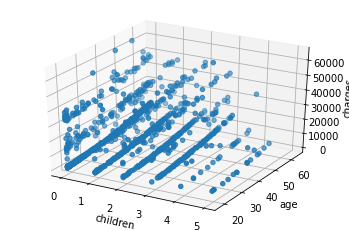

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(df['children'],df['age'],df['charges'])
ax.set_xlabel('children')
ax.set_zlabel('charges')
ax.set_ylabel('age')
plt.show()
fig.savefig("children_age_charges", transparent=True)

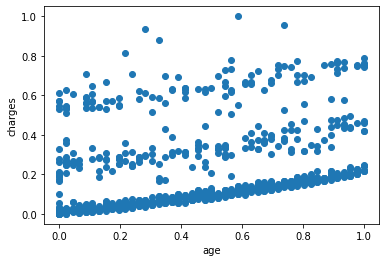

In [ ]:
    train = df.drop('bmi', axis=1).sample(frac=0.7)
    test = df.drop('bmi', axis=1).drop(train.index)
    
    X_train = train.iloc[:, 0:-1]
    y_train = train.iloc[:, -1]

    X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
    y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X_train['age'], y_train)
    ax.set_xlabel('age')
    ax.set_ylabel('charges')
    fig.show()
    fig.savefig("age_charges")

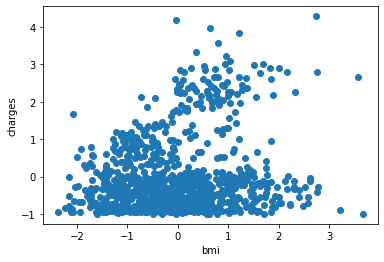

In [ ]:
    train = df.sample(frac=0.7)
    test = df.drop(train.index)
    
    X_train = train.iloc[:, 0:-1]
    y_train = train.iloc[:, -1]

    X_train = (X_train - X_train.mean()) / X_train.std()
    y_train = (y_train - y_train.mean()) / y_train.std()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X_train['bmi'], y_train)
    ax.set_xlabel('bmi')
    ax.set_ylabel('charges')
    fig.show()
    fig.savefig("bmi_charges")

In [ ]:
def split(df, frac):
    train = df.sample(frac=frac, random_state=200)
    test = df.drop(train.index)
    
    X_train = train.iloc[:, 0:-1].to_numpy()
    y_train = train.iloc[:, -1].to_numpy()
   
    X_train = (X_train - X_train.mean()) / X_train.std()
    y_train = (y_train - y_train.mean()) / y_train.std()

    X_train = np.array(X_train).reshape(-1,3)
    y_train = np.array(y_train).reshape(-1,1)

    X_train = np.hstack((np.ones((X_train.shape[0],1)), X_train))
    
    X_test = test.iloc[:, 0:-1]
    y_test = test.iloc[:, -1]
    
    X_test = (X_test - X_test.mean()) / X_test.std()
    y_test = (y_test - y_test.mean()) / y_test.std()
    
    X_test = np.array(X_test).reshape(-1,3)
    y_test = np.array(y_test).reshape(-1,1)

    X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test))
    
    return X_train, y_train, X_test, y_test

In [ ]:
def mse(coeff, X, y):
  pred = np.dot(X, coeff)
  return (1/y.shape[0])*np.sum(((y) - (pred))**2)

In [ ]:
def calc(regression_func, alpha = None, epochs = None):
  mse_test = np.zeros((20,1))
  mse_train = np.zeros((20,1))
  r2 = np.zeros((20,1))
  for i in range(20):
    X_train, y_train, X_test, y_test = split(df,0.7)
    if alpha is not None and epochs is not None:
      coeff = regression_func(X_train, y_train, X_test, y_test, alpha=alpha, epochs=epochs)
    else:
      coeff = regression_func(X_train, y_train)
    mse_test[i], mse_train[i] = mse(coeff, X_test, y_test), mse(coeff, X_train, y_train)
    pred = np.dot(X_test, coeff)
    u = ((pred - y_test)**2).sum()
    v = ((y_test - y_test.mean())**2).sum()
    r2[i] = 1-u/v
  # print(coeff)
  print(f'Test data error mean: {np.mean(mse_test)} , variance {np.var(mse_test)}')
  print(f'Train data error mean: {np.mean(mse_train)} , variance {np.var(mse_train)}')
  print(f'Test data error min: {np.min(mse_test)}')
  print(f'Train data error min: {np.min(mse_train)}')
  print(f'R2 mean: {np.mean(r2)}, variance {np.var(r2)}')

# Solving by Normal Equations

In [ ]:
def normal_equation(X_train, y_train):
  X = X_train
  y = y_train
  theta = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
  return theta

In [ ]:
calc(normal_equation)

Test data error mean: 1.488341765382138 , variance 0.0
Train data error mean: 0.8893516806921268 , variance 0.0
Test data error min: 1.488341765382138
Train data error min: 0.8893516806921268
R2 mean: -0.49206261979559385, variance 1.232595164407831e-32


## Gradient Descent

In [ ]:
def grad_GD(W, X, y):
      return X.T.dot(X.dot(W) - y) # d 1/2*(xW-y)**2 / dW  --> (xW-y)*X --> (ab)T = bTaT 

In [ ]:
def GD(X_train, y_train, X_test, y_test, alpha = 0.01, epochs = 1000, gitgraph = False):
  X = X_train
  y = y_train  
  mse_train = np.zeros((epochs,))
  mse_test = np.zeros((epochs,))
  W = np.random.rand(X.shape[1], 1) * 0.01
  for j in range(epochs):
      W = W - alpha/len(X) * grad_GD(W, X, y)
      if gitgraph:
        mse_train[j] = mse(W, X_train, y_train)
        mse_test[j] = mse(W, X_test, y_test)
      # if j % 50 == 0:
      #     print(((np.dot(X, W) - y) ** 2).sum())
  if gitgraph:
    return W, mse_train, mse_test
  return W

In [ ]:
calc(GD, 0.01, 1000)

Test data error mean: 0.920085568036134 , variance 2.53757311650577e-07
Train data error mean: 0.8943366261570856 , variance 2.694063253053569e-09
Test data error min: 0.9193501941987048
Train data error min: 0.894249258461644
R2 mean: 0.07761421804377558, variance 2.550276841920271e-07


# Stochastic Gradient Descent

In [ ]:
from random import randint
def grad_SGD(W, X, y):
    return X * (X.dot(W) - y)

def SGD(X_train, y_train, X_test, y_test, alpha = 0.01, epochs = 1000, gitgraph = False):
    X = X_train
    y = y_train
    W = np.random.rand(X.shape[1], 1) * 0.01
    mse_train = np.zeros((epochs,))
    mse_test = np.zeros((epochs,))
    for j in range(epochs):
        i = randint(0,len(X)-1)
        W = W - alpha * grad_SGD(W, X[i], y[i]).reshape(-1,1)
        if gitgraph:
              mse_train[j] = mse(W, X_train, y_train)
              mse_test[j] = mse(W, X_test, y_test)
        if j % 50 == 0:
            pass
            # print(((np.dot(X, W) - y) ** 2).sum())
    if gitgraph:
      return W, mse_train, mse_test
    return W


In [ ]:
def error_epoch(alpha= [0.01,0.001,0.0001], epochs=[1000,10000,100000]):
  X_train, y_train, X_test, y_test = split(df,0.7)
  for eta,epoch in zip(alpha,epochs):
    print(eta,epoch)
    plt.clf()
    fig = plt.figure()
    coeff, error_train, error_test = GD(X_train, y_train, X_test, y_test, eta, epoch, gitgraph = True)
    a1, = plt.plot(error_train, label="GD_train")
    a2, = plt.plot(error_test, label="GD_test")
    print(coeff)
    coeff, error_train, error_test = SGD(X_train, y_train, X_test, y_test, eta ,epoch, gitgraph = True)
    a3, = plt.plot(error_train, label="SGD_train")
    a4, = plt.plot(error_test, label="SGD_test")
    h = [a1,a2,a3,a4]
    plt.legend(handles = h)
    plt.title(f'Alpha = {eta}')
    plt.show()
    fig.savefig(f'Alpha{eta}.png')


In [ ]:
calc(SGD, 0.01, 1000)

Test data error mean: 0.9316946433382842 , variance 0.0008925344397527997
Train data error mean: 0.9049026950579174 , variance 6.0109264173147106e-05
Test data error min: 0.8744654466706081
Train data error min: 0.8950886566437519
R2 mean: 0.06597612005336977, variance 0.000897002690291813


0.01 1000
[[-0.14574605]
 [ 0.35618111]
 [ 0.31289255]
 [ 0.22035033]]


<Figure size 432x288 with 0 Axes>

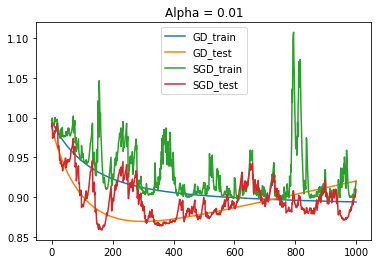

0.001 10000
[[-0.14517539]
 [ 0.35621677]
 [ 0.31001969]
 [ 0.21991665]]


<Figure size 432x288 with 0 Axes>

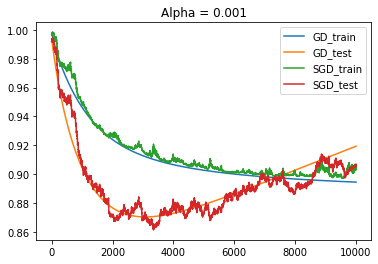

0.0001 100000
[[-0.1448381 ]
 [ 0.35613818]
 [ 0.31347964]
 [ 0.22125418]]


<Figure size 432x288 with 0 Axes>

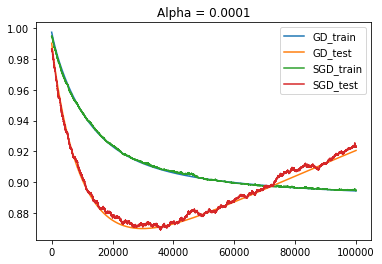

In [ ]:
error_epoch()